 <div>
 <h1><center>Applications de l'Informatique Quantique</h1>
<h2><center>Séance 2, Notebook 1 : Circuits variationnels - l'exemple du QSVM</h2>
<h3> Professeur: Durantin Gautier</h3>
</div>
    
    

### Objectifs du notebook
    
Ce notebook vise à introduire le design de circuits variationnels pour des applications concrètes, via l'exemple du Quantum Machine Learning. Ce notebook est un guide dans l'implémentation d'un modèle de type QSVM (Quantum Support Vector Machine).
L'application du modèle se fait sur un jeu de données ad_hoc, conçu pour être séparable par une feature map quantique, mais inséparable par une feature map classique. Il convient de **garder à l'esprit que cette situation ne représente qu'une infime partie des datasets rencontrés dans des problèmes réels**.
    
### Imports
    
Le notebook, comme la plupart des applications qui seront décrites dans ce module, s'appuie sur deux librairies principales :
- *qiskit* : pour la définition des circuits quantiques et leur préparation pour l'exécution
- *qiskit_aer* : pour la simulation du comportement des ordinateurs quantiques. Le module nous permettra d'exécuter nos circuits en pratique

Les librairies suivantes sont également requises pour les applications proposées ici :
- *scikit-learn* : pour l'implémentation et l'exécution des modèles de machine learning (ici le SVM)
- *numpy* : pour la récupération du dataset
- *matplotlib* : pour la visualisation des données

In [19]:
from qiskit.circuit import QuantumCircuit
from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_aer import AerSimulator

from sklearn.svm import SVC

import numpy as np
import time

import matplotlib.pyplot as plt

## 1. Chargement et visualisation des données

In [20]:
data_archive=np.load("data.npz")

X_train=data_archive["X_train"]
X_test=data_archive["X_test"]
y_train=data_archive["y_train"]
y_test=data_archive["y_test"]

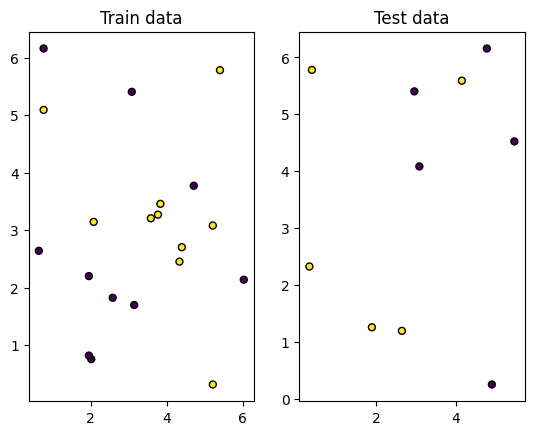

In [21]:
fig, (ax1,ax2) = plt.subplots(1,2)

ax1.scatter(X_train[:, 0], X_train[:, 1], marker="o", c=y_train, s=25, edgecolor="k")
ax1.title.set_text('Train data')
ax2.scatter(X_test[:, 0], X_test[:, 1], marker="o", c=y_test, s=25, edgecolor="k")
ax2.title.set_text('Test data')

## 2. Definition d'un Classifieur SVM classique

On cherche à entraîner une machine à vecteurs de support (SVM). On peut [retrouver ici une explication de la théorie des SVM](https://fr.wikipedia.org/wiki/Machine_%C3%A0_vecteurs_de_support).
L'élément central à retenir est que pour s'entrainer sur une tâche de classification, un SVM n'a besoin que de deux éléments :
 - la connaissance des **labels réels** des points de données du jeu d'entraînement
 - une matrice (nommée matrice de Gram ou matrice noyau) contenant **l'ensemble des produits scalaires entre tous les points de données**, pris deux à deux.
 
On commence par définir la fonction qui nous permet de calculer le produit scalaire entre deux vecteurs de données :

In [22]:
def scalar_product(x,y):
    return(np.dot(x,y))

La fonction utilitaire ci dessous, **qui sera réutilisée plusieurs fois dans cette séance**, permet de calculer la matrice noyau entre deux séries de points (X et Y), en utilisant la fopnction $kernel_function$ pour calculer chaque élément (pour le SVM classique, nous utiliserons donc le produit scalaire)

In [23]:
def compute_kernel(X,Y,kernel_function):
    start=time.time()
    ## Calcul de la matrice de Gram classique
    #initialisation de la matrice de Gram
    gram=np.ones((np.shape(X)[0],np.shape(Y)[0]))
    #Remplissage de la matrice de Gram
    for i,x in enumerate(X):
        for j,y in enumerate(Y):
            gram[i,j]=kernel_function(x,y)
    end=time.time()
    print("Time required to compute kernel : {} s".format(end-start))
    return(gram)

Pour entraîner le SVM, on calcule la mtrice noyau contenant les produits scalaires de tous les éléments de $X_train$ pris deux à deux :

Time required to compute kernel : 0.0 s


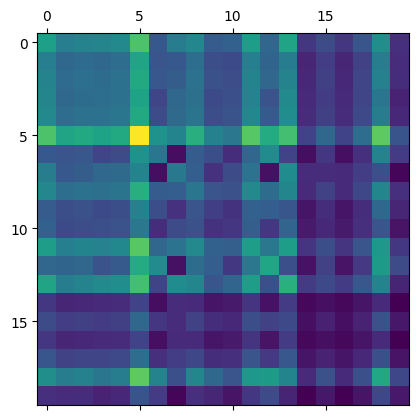

In [6]:
classical_kernel = compute_kernel(X_train,X_train,scalar_product)

plt.matshow(classical_kernel)

L'entraînement se fait en provisionant la matrice noyau et les labels d'entrainement ($y_train$)

In [7]:
classical_svm=SVC(kernel="precomputed")

classical_svm.fit(classical_kernel,y_train)

SVC(kernel='precomputed')

In [8]:
print("Accuracy Train : {}".format(classical_svm.score(classical_kernel,y_train)))

Accuracy Train : 0.75


Pour le test, le SVM nécessite une matrice noyau contenant les produits scalaires des éléments de $X_test$ et $X_train$ pris deux à deux :

Time required to compute kernel : 0.0 s


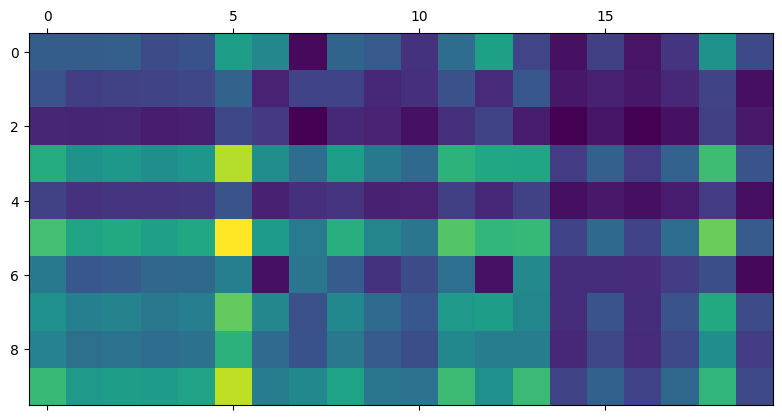

In [9]:
test_kernel = compute_kernel(X_test,X_train,scalar_product)

plt.matshow(test_kernel)

In [10]:
print("Accuracy Test : {}".format(classical_svm.score(test_kernel,y_test)))

Accuracy Test : 0.1


## 3. Application au QSVM

Dans le QSVM, on choisit **d'encoder le vecteur $x$ dans un état quantique, plutôt que d'utiliser sa valeur directement**

Ainsi, plutôt que d'utiliser les composantes de $x$ directement, on choisit un unitaire paramétrisable $U(x)$, et on représente $x$ par l'état $U(x)|0⟩$


<div class="alert alert-block alert-info">
<ul>
    <li>Implémenter une fonction prenant en entrée deux vecteurs $x$ et $y$, et renvoyant un circuit correspondant à l'état $U^{\dagger}(y)U(x)|0⟩$ (utilisez l'unitaire de votre choix)
    <li>Visualiser son bon fonctionnement en dessinant le circuit en utilisant les deux premiers points de données de X_train
</ul>
</div>

In [11]:
from qiskit.circuit.library import ZZFeatureMap

def quantum_kernel_circuit(x,y):
    zzfm=ZZFeatureMap(2,reps=1)
    q1=zzfm.assign_parameters(x)
    q2=zzfm.inverse().assign_parameters(y)
    qc=q1.compose(q2)
    qc.measure_all()
    return(qc)


In [12]:
quantum_kernel_circuit(X_train[0,:],X_train[1,:]).decompose().draw()

┌───┐ ┌──────────┐                                                  »
   q_0: ┤ H ├─┤ P(10.43) ├──■───────────────────■────■───────────────────■──»
        ├───┤┌┴──────────┤┌─┴─┐┌─────────────┐┌─┴─┐┌─┴─┐┌─────────────┐┌─┴─┐»
   q_1: ┤ H ├┤ P(6.1575) ├┤ X ├┤ P(-0.26056) ├┤ X ├┤ X ├┤ P(-0.05527) ├┤ X ├»
        └───┘└───────────┘└───┘└─────────────┘└───┘└───┘└─────────────┘└───┘»
meas: 2/════════════════════════════════════════════════════════════════════»
                                                                            »
«        ┌────────────┐┌───┐ ░ ┌─┐   
«   q_0: ┤ P(-7.1628) ├┤ H ├─░─┤M├───
«        ├────────────┤├───┤ ░ └╥┘┌─┐
«   q_1: ┤ P(-6.4088) ├┤ H ├─░──╫─┤M├
«        └────────────┘└───┘ ░  ║ └╥┘
«meas: 2/═══════════════════════╩══╩═
«                               0  1


<div class="alert alert-block alert-info">
<ul>
    <li>Montrer que le produit scalaire entre $x$ et $y$ correspond à la probabilité de mesurer l'état $|0⟩$ en sortie du circuit précédent
</ul>
</div>

$x$ est encodé dans l'état $U(x)|0⟩$, et $y$ dans l'état $U(y)|0⟩$
On a alors le produit scalaire suivant : $x.y = ⟨0|U^{\dagger}(y)U(x)|0⟩$


<div class="alert alert-block alert-info">
<ul>
    <li>Implémenter une fonction permettant d'estimer cette probabilité, en exécutant le circuit quantique à l'aide d'un Sampler
</ul>
</div>

In [13]:
def compute_distance(x,y):
    qc=quantum_kernel_circuit(x,y)
    sampler=Sampler()
    pass_manager = generate_preset_pass_manager(1, AerSimulator())
    isa_qc=pass_manager.run(qc)
    job=sampler.run([isa_qc],shots=1024)
    return(job.result()[0].data.meas.get_counts().get('00',0)/1024)

<div class="alert alert-block alert-info">
<ul>
    <li>Utiliser la fonction définie précédemment pour entraîner et tester un QSVM (il faudra utiliser la fonction utilitaire $compute_kernel$ définie en début de notebook)
    <li>Sur ce jeu de données, que donnent les performances en comparaison des performances d'un SVM classique ? (par performance, on fait référence à la fois à l'accuracy obtenue ainsi qu'au temps requis pour les calculs)
</ul>
</div>

Time required to compute kernel : 41.2940948009491 s


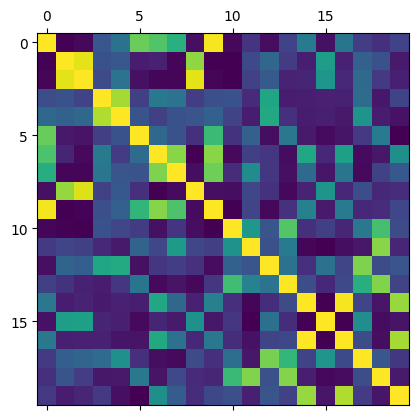

In [14]:
quantum_kernel = compute_kernel(X_train,X_train,compute_distance)

plt.matshow(quantum_kernel)

In [15]:
quantum_svm=SVC(kernel="precomputed")

quantum_svm.fit(quantum_kernel,y_train)

SVC(kernel='precomputed')

In [16]:
print("Accuracy Train : {}".format(quantum_svm.score(quantum_kernel,y_train)))

Accuracy Train : 1.0


Time required to compute kernel : 19.523069143295288 s


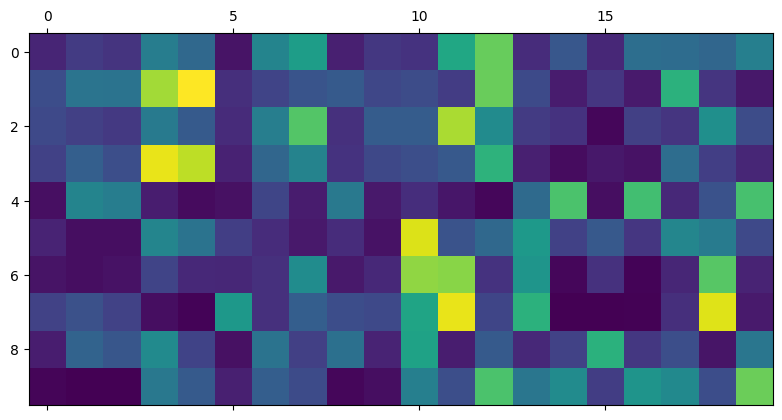

In [17]:
test_kernel = compute_kernel(X_test,X_train,compute_distance)

plt.matshow(test_kernel)

In [18]:
print("Accuracy Test : {}".format(quantum_svm.score(test_kernel,y_test)))

Accuracy Test : 0.7
